## Project Luther - Movie Data

**Client:**  Aragon Soma Entertainment (Movie Production Company)
   * U.K. gross revenue has been stagnant over the past few years
   * What can we do to pull in a larger audience in the U.K. and maximize revenue?

**Data**:  Box Office Mojo, Wikipedia
  * Scraped over 15,000 movies and narrowed it down to 1,300 U.S. movies that had U.K. revenue
  * Scraped Wikipedia for names of all British actors/actresses

#### I first import the modules I will be using and define some functions that will be used throughout my project.  BeautifulSoup is used to take the HTML of the webpage and outputs a soup object that allows me to search for certain tags/attributes/text.

In [1]:
import urllib2
from bs4 import BeautifulSoup
import pickle
import datetime
import pandas as pd
import json
import csv
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
% matplotlib inline

#### Build pages

In [3]:
def build_soup_page(page = "", url = "", use_url=False):
    """
    builds a beautifulsoup object from a url if a url is passed, otherwise just creates a BeautifulSoup object
    """
    if use_url:
        page = urllib2.urlopen(url)
        soup = BeautifulSoup(page, 'xml')
    else:
        soup = BeautifulSoup(page)
    return soup

In [4]:
def build_top_index(soup, to_search, beg_url):
    """
    builds an index from a soup object with a search string
    """
    
    index = []
    
    for a in soup.find_all('a', href=True):
        if a['href'].startswith(to_search):
            index.append(beg_url + a['href'])
    end_index = len(index) / 2
    
    return index[:end_index]

In [5]:
def build_sub_index(soup, search_one, search_two, beg_url):
    """
    builds an index from a soup object with a search and count string
    """
    
    index = []
    
    for a in soup.find_all('a', href=True):
        if a['href'].startswith(search_one) and re.search(search_two, a['href']) != None:
            index.append(beg_url + a['href'])
    end_index = len(index) / 2
    
    return index[:end_index]

In [6]:
def build_single_movie_url_list(total_urls, box_url):
    """
    builds a list of every movies url
    """
    
    single_movie_url_tags = []

    for full_site in total_urls:
        soup = build_soup_page(full_site)
        for a in soup.find_all('a', href=True):
            if re.search('id', a['href']) != None and a['href'] not in single_movie_url_tags:
                single_movie_url_tags[box_url + a['href']] = soup
                #single_movie_url_tags.append(box_url + a['href'])   
    return set(single_movie_url_tags)

#### Pickle (save a file) of things as needed

In [3]:
def store_pickles(filename, to_store):
    with open(filename, 'w') as f:
        pickle.dump(to_store, f)
        
def eat_pickles(filename):
    with open(filename, 'r') as f:
        return pickle.load(f)

#### Title

In [8]:
def get_movie_title(soup):
    """
    takes a soup object of a movie page, and returns the title
    """
    return str(soup.find('title').text.split("(")[0].strip())

#### Movie Gross

In [9]:
def get_movie_gross(soup):
    """
    takes a soup object of a movie page, finds the value for the movie gross, replaces a few characters and returns
    it as an integer
    """
    obj = soup.find(text = re.compile('Domestic Total Gross'))
    if not obj:
        return None
    movie_gross = obj.findNextSibling().text
    if movie_gross:
        return int(movie_gross.replace(',','').replace('$', ''))
    else:
        return None 

#### Release Date

In [10]:
def get_movie_release_date(soup):
    """
    takes a soup object of a movie page, finds the value for the release date, converts it to a datetime object
    and returns the object in date format YYYY-MM-DD
    """
    obj = soup.find(text = re.compile('Release Date'))
    if not obj:
        return None
    release_date = obj.findNextSibling().text
    if release_date != 'N/A':
        if release_date == 'TBD':
            return str(release_date)
        elif len(release_date.split()) == 3:
            return datetime.datetime.strptime(release_date, '%B %d, %Y').date()
        elif len(release_date.split()) == 1:
            return datetime.datetime.strptime(release_date, '%Y').date()
        
        else:
            return None

#### Runtime

In [11]:
def get_movie_runtime(soup):
    """
    takes a soup object of a movie page, finds the value for the runtime, splits the string and returns an integer
    of total minutes.
    """
    obj = soup.find(text = re.compile('Runtime'))
    if not obj:
        return None
    runtime = obj.findNextSibling().text
    if runtime and runtime != 'N/A':
        return int(runtime.split(' ')[0]) * 60 + int(runtime.split(' ')[2])      
    else:
        return None 

#### Budget

In [12]:
def get_movie_budget(soup):
    """
    takes a soup object of a movie page, finds the value for the budget, splits the string and returns an integer
    of budget.
    """
    obj = soup.find(text = re.compile('Production Budget'))
    if not obj:
        return None
    budget = obj.findNextSibling().text
    if budget and budget != 'N/A':
        if '.' in budget:
            return int(budget.split()[0].split('.')[0].replace('$', '') + budget.split()[0].split('.')[1] + '00000')
        elif ',' in budget:
            return int(budget.split(',')[0].replace('$', '') + budget.split(',')[1])
        else:
            return int(budget.split()[0].replace('$', '') + '000000')
    else:
        return None 

#### Rating

In [13]:
def get_movie_rating(soup):
    """
    takes a string attribute of a movie on the page, and returns the string in the next
    sibling object (the value for that attritube)
    """
    obj = soup.find(text = re.compile('Rating'))
    if not obj:
        return None
    rating = obj.findNextSibling().text
    if rating:
        return str(rating)
    else:
        return None 

#### Foreign Total Gross

In [14]:
def get_movie_foreign_gross(soup):
    """
    takes a soup object of a movie page, finds the value for the movie gross, replaces a few characters and returns
    it as an integer
    """
    obj = soup.find_all(width="35%")
    if not obj:
        return None
    if len(obj) > 1:
        foreign_tot_gross = obj[1].text.strip()
        if foreign_tot_gross != 'n/a':
            return int(''.join(foreign_tot_gross.replace('$','').split(',')))
    else:
        return None 

#### Genre

In [15]:
def get_movie_genre(soup):
    """
    takes a string attribute of a movie on the page, and returns the string in the next
    sibling object (the value for that attritube)
    """
    obj = soup.find(text = re.compile("Genre: "))
    if not obj:
        return None
    genre = obj.findNextSibling().text
    if genre:
        return str(genre)
    else:
        return None 

#### Distributor

In [16]:
def get_movie_distributor(soup):
    """
    takes a string attribute of a movie on the page, and returns the string in the next
    sibling object (the value for that attritube)
    """
    obj = soup.find(text = re.compile("Distributor"))
    if not obj:
        return None
    dist = obj.findNextSibling().text
    if dist:
        return str(dist)
    else:
        return None 

#### Actors

In [17]:
def get_movie_actors(soup):
    
    actor_list = []

    for a in soup.find_all('a', href=True):
        if a['href'].startswith('/people/chart/?view=Actor'):
            section = a.find_parent('font')
            for i in range(0, len(section), 2):
                try:
                    actor_list.append(str(section.contents[i].text))
                except:
                    try:
                        actor_list.append(str(section.contents[i]))
                    except:
                        actor_list.append(section.contents[i])
    return list(set(actor_list))

####Build an index of movie pages from A-Z

In [427]:
# creates a soup object containing the href for all pages A-Z & NUM
#movie_pages_az_level = build_soup_page("http://www.boxofficemojo.com/movies")

# builds a list of each url ending for NUM and A-Z movie pages
#movie_pages_az_urls = build_top_index(movie_pages_az_level, 'alphabetical', "http://www.boxofficemojo.com/movies/")

#### Build sub level pages for each letter of title, also pickled (top_pages.pkl)

In [ ]:
# Builds total urls for all pages of movies
#total_urls = movie_pages_az_urls[:]

#for movie_page in movie_pages_az_urls:
#    top_level_soup = build_soup_page(movie_page)
#    sub_level = build_sub_index(top_level_soup, '/movies/', 'page', "http://www.boxofficemojo.com")
#    if len(sub_level) > 0:
#        for sub_level_url in sub_level:
#            if sub_level_url.count('id') == 0:
#                total_urls.append(sub_level_url)

###Begin here:  In order to save time and not hit box office mojo's server so many times, I've used a pickled file of almost all the movies on the website created by a colleague.

In [4]:
jar_of_pickles = eat_pickles('page_data.pkl')

We have 15,394 movie page data to explore

In [30]:
len(jar_of_pickles)

15394

In [6]:
#jar_of_pickles.items()[0]

####Filter the movie pages and compile a list of movies that only have a foreign revenue page (otherwise that movie would have no U.K. revenue).

In [ ]:
foreign_pages = []

for url, html in jar_of_pickles.iteritems():
    movie_soup = build_soup_page(html)
    if movie_soup.find(attrs={'href': re.compile('page=intl')}) != None:
        foreign_pages.append(url)

#### Create the url's for each movie's foreign revenue page by splitting the main page and inserting the 'page=intl' so I can scrape those pages for U.K. revenue.

In [ ]:
foreign_urls = [str(foreign_pages[i]).split('?')[0] + '?page=intl&' + \
                str(foreign_pages[i]).split('?')[1] for i in range(len(foreign_pages))]

####Having pickled the file already on the first pass, I will just use that file going forward to avoid hitting the servers.

In [20]:
foreign_url_pages = eat_pickles('foreign_url_pages.pkl')

We have filtered down to 7,529 movies that have some kind of foreign movie revenue

In [21]:
len(foreign_url_pages)

7529

### Foreign Gross for U.K.

#### Loop through pages that have foreign box office revenue and build a list of dictionaries with keys as countries and values as gross.

In [23]:
foreign_movie_data = []

for url, html in foreign_url_pages.iteritems():
    soup = build_soup_page(page=html)
    foreign_movie_country = []
    foreign_country_gross = []
    for a in soup.find_all('a', href=True):
        if a['href'].startswith('/movies/?page=intl&country'):
            table = a.find_parent('tr')
            foreign_movie_country.append(str(table.contents[0].text))
            try:
                foreign_country_gross.append(int(''.join(table.contents[10].text.replace('$', '').split(','))))
            except:
                continue
    foreign_movie_data.append(dict(zip(foreign_movie_country, foreign_country_gross))) 

#### Build a dictionary with the foreign urls as keys and the values as a dictionary of movie country and gross

In [26]:
foreign_movie_dict = dict(zip(foreign_url_pages.keys(), foreign_movie_data))

In [274]:
foreign_movie_dict.items()[:2]

[('http://www.boxofficemojo.com/movies/?page=intl&id=sorcererandthewhitesnake.htm',
  {'FOREIGN TOTAL': 2100000,
   'Hong Kong': 408897,
   'Malaysia': 1336639,
   'New Zealand': 36404,
   'Philippines': 163718,
   'Singapore': 648229,
   'Thailand': 376587}),
 ('http://www.boxofficemojo.com/movies/?page=intl&id=rec4.htm',
  {'Argentina': 118689,
   'Belgium': 116573,
   'Ecuador': 970016,
   'FOREIGN TOTAL': 208846,
   'France': 686455,
   'Peru': 182292,
   'Poland': 158058,
   'Russia - CIS': 1259390})]

#### Now we must build a dictionary with urls as keys and U.K. gross as values

In [35]:
for k, v in foreign_movie_dict.iteritems():
    if len(v) == 1:
        soup = build_soup_page(foreign_url_pages[k])
        if soup.find(text = re.compile('United Kingdom')):
            v['United Kingdom'] = v.pop('FOREIGN TOTAL')

In [36]:
uk_movie_gross = {}

for k, v in foreign_movie_dict.iteritems():
    if 'United Kingdom' in v.keys():
        uk_movie_gross[k] =  v['United Kingdom']

In [37]:
uk_movie_gross.items()[:5]

[('http://www.boxofficemojo.com/movies/?page=intl&id=xfiles2.htm', 4391760),
 ('http://www.boxofficemojo.com/movies/?page=intl&id=pacificrim.htm',
  12785909),
 ('http://www.boxofficemojo.com/movies/?page=intl&id=deliverusfromevil.htm',
  19002),
 ('http://www.boxofficemojo.com/movies/?page=intl&id=insidedeepthroat.htm',
  17952),
 ('http://www.boxofficemojo.com/movies/?page=intl&id=beautyandthebeast3d.htm',
  4594648)]

### Wikipedia British Actors

In [38]:
brit_actors = build_soup_page(url='http://en.wikipedia.org/wiki/List_of_British_actors_and_actresses', use_url=True)

####After wikipedia has been scraped and a soup object has been created, I build a list of all actor's names.  Note:  some names had unicode lettering so I had to split those out and deal with them separately, otherwise I get an error.

In [39]:
brit_actors_list = []
unicode_list = []

for a in brit_actors.find_all('a', href=True):
    if a['href'].startswith('/wiki/'):
        try:
            brit_actors_list.append(str(a.text))
        except:
            unicode_list.append(a.text)

####There were some extra information in the list not related to names; below I spliced the list to remove those non-names.

In [44]:
brit_actors_list = brit_actors_list[11:-283]

#### Here I appended some of the unicode error names

In [45]:
to_append = ['Chloe Annett', 'Noel Coward', 'Ciaran Hinds', 'Llyr Lfans', 'Zoe Lister', 'Sinead Moynihan' \
                       'Sian Phillips', 'Zoe Wanamaker']

for name in to_append:
    brit_actors_list.append(name)

I end up with 1,074 British actor/actress names

In [46]:
len(brit_actors_list)

1074

In [47]:
brit_actors_list[:5]

['Amanda Abbington',
 'Joss Ackland',
 'Jenny Agutter',
 'Caroline Aherne',
 'Holly Aird']

### Now it is time to build the data structure to house my movies' url, title, domestic total gross, release date, actor, and U.K. total gross for further analysis

In [48]:
uk_movie_gross = eat_pickles('uk_movie_gross_final.pkl')

We are starting with 2,343 movies that have U.K. revenue.

In [56]:
len(uk_movie_gross)

2343

####To start, I look through my uk_movie_gross dictionary, and with the foreign page url key, I compile the main movie page url, and use that to index into the full url dictionary that contains the main page html.  Once I have the main movie page html, I create lists of all my attributes with functions used to search for what I want.

In [107]:
title = []
domestic_total_gross = []
release_date = []
budget = []
genre = []
uk_total_gross = []
BOM_url = []
actor_list = []

for url in uk_movie_gross.iterkeys():
    main_page = url[:37] + url[47:]
    main_html = jar_of_pickles[main_page]
    soup = build_soup_page(page=main_html)
    #Title
    title.append(get_movie_title(soup))
    #Domestic Total gross
    domestic_total_gross.append(get_movie_gross(soup))
    #Release Date
    release_date.append(get_movie_release_date(soup))
    #U.K. Total Gross
    uk_total_gross.append(uk_movie_gross[url])
    #Box office mojo URL
    BOM_url.append(main_page)
    #Actor lists
    actor_list.append(get_movie_actors(soup))
    #Genre
    genre.append(get_movie_genre(soup))
    #Budget
    budget.append(get_movie_budget(soup))

####Below, I combine all the data into a list of tuples for each movie

In [120]:
movie_data = zip(BOM_url, title, domestic_total_gross, release_date, budget, uk_total_gross, actor_list, genre)

In [121]:
movie_data[:2]

[('http://www.boxofficemojo.com/movies/?id=xfiles2.htm',
  'The X-Files: I Want to Believe',
  20982478,
  datetime.date(2008, 7, 25),
  30000000,
  4391760,
  ['Amanda Peet', 'David Duchovny', 'Gillian Anderson'],
  'Sci-Fi Thriller'),
 ('http://www.boxofficemojo.com/movies/?id=pacificrim.htm',
  'Pacific Rim',
  101802906,
  datetime.date(2013, 7, 12),
  190000000,
  12785909,
  ['Charlie Day',
   'Rinko Kikuchi',
   'Idris Elba',
   'Ron Perlman',
   'Charlie Hunnam'],
  'Sci-Fi Action')]

Convert each movie data tuple to a list to make it easier to work with

In [122]:
movie_data = [list(movie) for movie in movie_data]

####Since there are so many different genres, I have to cut the list down to a more general, clean set.

In [123]:
for movie in movie_data:
    if movie[-1].startswith('Action'):
        movie[-1] = 'Action'
    elif movie[-1].startswith('Adventure'):
        movie[-1] = 'Adventure'
    elif movie[-1].startswith('Animation'):
        movie[-1] = 'Animation'
    elif movie[-1].startswith('Comedy'):
        movie[-1] = 'Comedy'
    elif movie[-1].startswith('Concert'):
        movie[-1] = 'Concert'
    elif movie[-1].startswith('Crime'):
        try:
            split_g = movie[-1].split(' ')
            movie[-1] = split_g[0].strip()
        except:
            movie[-1] = 'Crime'
    elif movie[-1].startswith('Documentary'):
        movie[-1] = 'Documentary'
    elif movie[-1].startswith('Drama'):
        movie[-1] = 'Drama'
    elif movie[-1].startswith('Family'):
        try:
            split_g = movie[-1].split(' ')
            movie[-1] = split_g[0].strip()
        except:
            movie[-1] = 'Family'
    elif movie[-1].startswith('Fantasy'):
        try:
            split_g = movie[-1].split(' ')
            movie[-1] = split_g[0].strip()
        except:
            movie[-1] = 'Fantasy'
    elif movie[-1].startswith('Foreign'):
        try:
            split_g = movie[-1].split('/')
            movie[-1] = split_g[0].strip()
        except:
            movie[-1] = 'Foreign'
    elif movie[-1].startswith('Historical'):
        try:
            split_g = movie[-1].split(' ')
            movie[-1] = split_g[0].strip()
        except:
            movie[-1] = 'Epic'
    elif movie[-1].startswith('Horror'):
        movie[-1] = 'Horror'
    elif movie[-1].startswith('IMAX'):
        movie[-1] = 'IMAX'
    elif movie[-1].startswith('Music'):
        try:
            split_g = movie[-1].split(' ')
            movie[-1] = split_g[0].strip()
        except:
            movie[-1] = 'Drama'
    elif movie[-1].startswith('Musical'):
        movie[-1] = 'Musical'
    elif movie[-1].startswith('Period'):
        try:
            split_g = movie[-1].split(' ')
            movie[-1] = split_g[0].strip()
        except:
            movie[-1] = 'Period'
    elif movie[-1].startswith('Romance'):
        movie[-1] = 'Romance'
    elif movie[-1].startswith('Romantic'):
        try:
            split_g = movie[-1].split(' ')
            movie[-1] = split_g[0].strip()
        except:
            movie[-1] = 'Romance'
    elif movie[-1].startswith('Sci-Fi'):
        try:
            split_g = movie[-1].split(' ')
            movie[-1] = split_g[0].strip()
        except:
            movie[-1] = 'Sci-Fi'
    elif movie[-1].startswith('Sports'):
        try:
            split_g = movie[-1].split(' ')
            movie[-1] = split_g[0].strip()
        except:
            movie[-1] = 'Sports'
    elif movie[-1].startswith('Thriller'):
        movie[-1] = 'Thriller'
    elif movie[-1].startswith('Unknown'):
        movie[-1] = 'Unknown'
    elif movie[-1].startswith('War'):
        try:
            split_g = movie[-1].split(' ')
            movie[-1] = split_g[0].strip()
        except:
            movie[-1] = 'War'
    elif movie[-1].startswith('Western'):
        try:
            split_g = movie[-1].split(' ')
            movie[-1] = split_g[0].strip()
        except:
            movie[-1] = 'Western'

In [130]:
movie_data[:2]

[['http://www.boxofficemojo.com/movies/?id=xfiles2.htm',
  'The X-Files: I Want to Believe',
  20982478,
  datetime.date(2008, 7, 25),
  30000000,
  4391760,
  ['Amanda Peet', 'David Duchovny', 'Gillian Anderson'],
  'Sci-Fi'],
 ['http://www.boxofficemojo.com/movies/?id=pacificrim.htm',
  'Pacific Rim',
  101802906,
  datetime.date(2013, 7, 12),
  190000000,
  12785909,
  ['Charlie Day',
   'Rinko Kikuchi',
   'Idris Elba',
   'Ron Perlman',
   'Charlie Hunnam'],
  'Sci-Fi']]

###Now I want to try to add as much more additional data that I may be missing.  For example, there are movies that don't have actors listed in them; also I want to add the country associated with the movie as I only want U.S. movies.

####I start by looping through the actor list to find the index of movies that don't have a list of actors; then I index into the title list to find the titles I will need to scrape on 

In [63]:
titles_to_scrape = [title[i] for i, actors in enumerate(actor_list) if len(actors) == 0]

I have 466 movies that don't contain any actor information

In [65]:
len(titles_to_scrape)

466

In [67]:
titles_to_scrape[:5]

['Deliver Us from Evil',
 'Inside Deep Throat',
 'Beauty and the Beast',
 'Ong Bak: The Thai Warrior',
 'American Teen']

####Now it is time to loop through list of movies and gather titles to get country info

In [72]:
country_titles = [el[1] for el in movie_data]

In [73]:
country_titles[:5]

['The X-Files: I Want to Believe',
 'Pacific Rim',
 'Deliver Us from Evil',
 'Inside Deep Throat',
 'Beauty and the Beast']

####In order to try to locate this additonal information, I will connect to the OMDB API which has a vast amount of movie data and may contain what I am looking for.  I do a call for actors and countries separately.

In [132]:
new_actor_list = []
#country_list = []


for movie_title in titles_to_scrape:# titles_to_scrape instead of country_titles for actors
    title = movie_title.replace(" ", "+")
    base_url = 'http://www.omdbapi.com/?t='
    url_4 = base_url + title + '&y=&plot=short&r=json'
    
    try:
        page_4 = urllib2.urlopen(url_4).read()
        json_data = json.loads(page_4) # converts API json response to dict
        actors = json_data['Actors']
        actors = actors.split(',')
        try:
            new_actor_list.append([str(actor).strip() for actor in actors]) # trys to convert the name to a string
        except:
            new_actor_list.append([actor for actor in actors]) # otherwise it is unicode and I take it as it is
        #country = json_data['Country']
        #countries = country.split(',')
        #country_list.append([str(country).strip() for country in countries])
    except:
        new_actor_list.append([])
        #country_list.append([])

In [133]:
new_actor_list[:5]

[[u'Eric Bana', u' \xc9dgar Ram\xedrez', u' Olivia Munn', u' Chris Coy'],
 ['Dennis Hopper', 'Gerard Damiano', 'John Waters', 'Larry Flynt'],
 ["Paige O'Hara", 'Robby Benson', 'Richard White', 'Jerry Orbach'],
 [],
 ['Jake Tusing', 'Megan Krizmanich', 'Colin Clemens', 'Mitch Reinholt']]

In [81]:
country_list[:5]

[['USA', 'Canada'], ['USA'], ['USA'], ['USA'], ['USA']]

#### Unpack country and movie title and append to the movie data

In [134]:
add_country_to_movie_data = zip(country_titles, country_list)

for el in add_country_to_movie_data:
    for movie in movie_data:
        if el[0] in movie:
            movie.append(el[1])

####Unpack the title and actors, then loops through the movie data and extends the actors to the empty list

In [136]:
add_actors_to_movie_data = zip(titles_to_scrape, new_actor_list)

for el in add_actors_to_movie_data:
    for movie in movie_data:
        if el[0] in movie and len(movie[6]) == 0:
            movie[6].extend(el[1])

####Loops through movie data and appends a 1 or 0 depending on if there is a british actor/actress in the movie

In [137]:
for movie in movie_data:
    if len(movie[6]) > 1:
        for actor in movie[6]:
            if actor in brit_actors_list:
                movie.append(1)
                break
        if movie[-1] not in [0,1]:
            movie.append(0)
    else:
        movie.append(0)

In [139]:
movie_data[:3]

[['http://www.boxofficemojo.com/movies/?id=xfiles2.htm',
  'The X-Files: I Want to Believe',
  20982478,
  datetime.date(2008, 7, 25),
  30000000,
  4391760,
  ['Amanda Peet', 'David Duchovny', 'Gillian Anderson'],
  'Sci-Fi',
  ['USA', 'Canada'],
  0],
 ['http://www.boxofficemojo.com/movies/?id=pacificrim.htm',
  'Pacific Rim',
  101802906,
  datetime.date(2013, 7, 12),
  190000000,
  12785909,
  ['Charlie Day',
   'Rinko Kikuchi',
   'Idris Elba',
   'Ron Perlman',
   'Charlie Hunnam'],
  'Sci-Fi',
  ['USA'],
  1],
 ['http://www.boxofficemojo.com/movies/?id=deliverusfromevil.htm',
  'Deliver Us from Evil',
  201275,
  datetime.date(2006, 10, 13),
  None,
  19002,
  [u'Eric Bana', u' \xc9dgar Ram\xedrez', u' Olivia Munn', u' Chris Coy'],
  'Documentary',
  ['USA'],
  0]]

### I write my data structre to a csv below so I can have a copy and work with it in pandas

In [7]:
#with open('movie_data.csv', 'w') as csvfile:
#    csvwriter = csv.writer(csvfile)

#    i = 0
#    for movie in sorted(movie_data):
#        csvwriter.writerow(movie)
#        print 'row %i written' % i
#        i += 1
#    print 'success'

###Read the csv movie data into pandas

In [235]:
movie_df = pd.read_csv('movie_data.csv', usecols=[1,2,4,5,6,7,8,9])

In [236]:
movie_df.head()

,Title,Domestic_Total_Gross,Budget,UK_Total_Gross,Actors,Genre,Country,British
0,"10,000 B.C.",94784201,105000000,11349484,['N/A'],Adventure,['USA'],0
1,After Earth,60522097,130000000,9737192,"['Jaden Smith', 'Will Smith']",Sci-Fi,['USA'],0
2,The Hundred-Foot Journey,54240821,22000000,4364114,"['Helen Mirren', 'Charlotte LeBon']",Drama,"['India', 'United Arab Emirates', 'USA']",1
3,The 11th Hour,707343,NaN,2457,"['(Narrator)', 'Leonardo DiCaprio*']",Documentary,['USA'],0
4,127 Hours,18335230,18000000,12513887,"['Clemence Posey', 'James Franco', 'Treat Will...",Drama,"['USA', 'UK']",0


Started with 2,343 movies

In [237]:
len(movie_df)

2343

In [238]:
# Get started on some clean up work on the dataframe
movie_df.replace("['N/A']", np.nan, inplace=True)
# Drop NaN rows
movie_df.dropna(inplace=True)
# Only keep movies that have USA in the country
movie_df = movie_df[['USA' in country for country in movie_df.Country.values]]

In [239]:
movie_df.head()

,Title,Domestic_Total_Gross,Budget,UK_Total_Gross,Actors,Genre,Country,British
1,After Earth,60522097,130000000,9737192,"['Jaden Smith', 'Will Smith']",Sci-Fi,['USA'],0
2,The Hundred-Foot Journey,54240821,22000000,4364114,"['Helen Mirren', 'Charlotte LeBon']",Drama,"['India', 'United Arab Emirates', 'USA']",1
4,127 Hours,18335230,18000000,12513887,"['Clemence Posey', 'James Franco', 'Treat Will...",Drama,"['USA', 'UK']",0
5,13 Going on 30,57231747,37000000,9346533,"['Mark Ruffalo', 'Jennifer Garner']",Comedy,['USA'],0
6,1408,71985628,25000000,6482080,"['John Cusack', 'Samuel L. Jackson', 'Tony Sha...",Horror,['USA'],0


End up with 1,238 movies to work with

In [240]:
len(movie_df)

1238

####Let's take a look at how the movies are dispersed as far as containing a British actor or not.

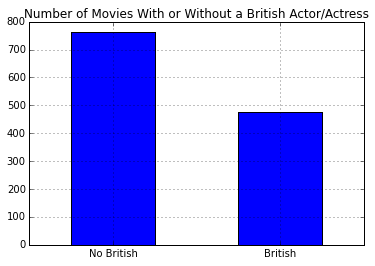

In [241]:
brit_df = pd.DataFrame(movie_df.British.value_counts().values, index=['No British', 'British'])
brit_df.plot(kind='bar', rot=0, legend=False, title='Number of Movies With or Without a British Actor/Actress')

As you can see, there's about 1.6 times as many movies that don't contain a British actor than those that do

####It is time to use linear regression to model the potential effect on UK revenue of having a British actor in your movie.  For predictor variable, I will be using the budget of the movie and the genre along with the british 1 or 0.  But first, should any of these variables be transformed?

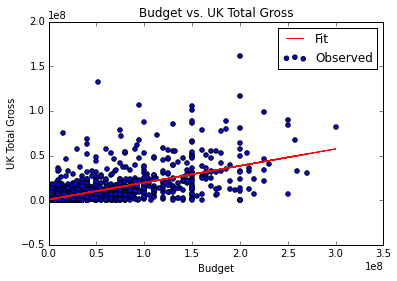

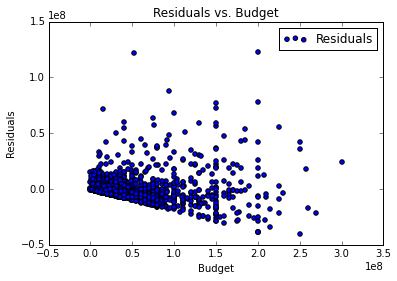

In [255]:
# Let's first run a simple model using only budget
model_1 = smf.ols("UK_Total_Gross ~ Budget", movie_df).fit()

# Plots budget against gross and plots the line of best fit (predictions).
plt.figure()
plt.scatter(movie_df.Budget, movie_df.UK_Total_Gross, label='Observed')
best_fit = model_1.params['Intercept'] + model_1.params['Budget'] * movie_df.Budget
plt.plot(movie_df.Budget, best_fit, 'r', label='Fit')
plt.xlabel('Budget')
plt.ylabel('UK Total Gross')
plt.title('Budget vs. UK Total Gross')
plt.legend(loc='best')
plt.xlim(0.0)
 
plt.figure()
plt.scatter(movie_df.Budget, model_1.resid, label='Residuals')
plt.xlabel('Budget')
plt.ylabel('Residuals')
plt.title('Residuals vs. Budget')
plt.legend(loc='best')

It appears that there is a cone shape to the residuals of this model.  There is much more variation in the residuals as budget gets larger whereas it should be more normally distributed around 0.  In other words, the higher the budget gets, the less accurate our predictions are.  In order to control for this, we transform the budget to be the log of the budget and also take the log of the UK Total Gross.

###Now we run a linear model predicting log of the UK Total Gross using the covariates log of the budget, the genre and british

In [273]:
smf.ols("np.log(UK_Total_Gross) ~ np.log(Budget) * Genre + British", \
        movie_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     np.log(UK_Total_Gross)   R-squared:                       0.296
Model:                                OLS   Adj. R-squared:                  0.276
Method:                     Least Squares   F-statistic:                     14.85
Date:                    Sat, 09 May 2015   Prob (F-statistic):           1.78e-69
Time:                            20:33:50   Log-Likelihood:                -2360.1
No. Observations:                    1238   AIC:                             4790.
Df Residuals:                        1203   BIC:                             4969.
Df Model:                              34                                         
Covariance Type:                nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------
Intercept                              -4.9405      2.710     -1.823      0.069       -10.257     0.376
Genre[T.Adventure]                      1.4669      6.423      0.228      0.819       -11.134    14.068
Genre[T.Animation]                      2.1417      6.151      0.348      0.728        -9.926    14.209
Genre[T.Comedy]                         6.5543      3.341      1.962      0.050        -0.001    13.109
Genre[T.Concert]                     -342.0839    356.164     -0.960      0.337     -1040.855   356.687
Genre[T.Crime]                          0.6973     85.396      0.008      0.993      -166.845   168.240
Genre[T.Documentary]                   15.5285      6.045      2.569      0.010         3.668    27.389
Genre[T.Drama]                          7.8929      3.038      2.598      0.009         1.933    13.853
Genre[T.Epic]                         -16.8090    147.250     -0.114      0.909      -305.705   272.087
Genre[T.Family]                         5.2529     29.702      0.177      0.860       -53.020    63.525
Genre[T.Fantasy]                       -5.4470     12.238     -0.445      0.656       -29.456    18.562
Genre[T.Horror]                        18.9327      3.085      6.138      0.000        12.881    24.984
Genre[T.Romance]                       -3.3455      8.143     -0.411      0.681       -19.322    12.631
Genre[T.Sci-Fi]                        10.1914      4.719      2.160      0.031         0.933    19.449
Genre[T.Thriller]                      13.8829      4.742      2.928      0.003         4.579    23.187
Genre[T.War]                           -9.2682     13.167     -0.704      0.482       -35.101    16.565
Genre[T.Western]                        1.5917     11.756      0.135      0.892       -21.474    24.657
British[T.1]                            0.3247      0.106      3.059      0.002         0.116     0.533
np.log(Budget)                          1.1279      0.151      7.461      0.000         0.831     1.425
np.log(Budget):Genre[T.Adventure]      -0.0666      0.353     -0.189      0.850        -0.758     0.625
np.log(Budget):Genre[T.Animation]      -0.0781      0.337     -0.231      0.817        -0.740     0.584
np.log(Budget):Genre[T.Comedy]         -0.3515      0.189     -1.860      0.063        -0.722     0.019
np.log(Budget):Genre[T.Concert]        21.4154     22.169      0.966      0.334       -22.079    64.910
np.log(Budget):Genre[T.Crime]           0.0109      4.813      0.002      0.998        -9.432     9.454
np.log(Budget):Genre[T.Documentary]    -0.9890      0.390     -2.534      0.011        -1.755    -0.223
np.log(Budget):Genre[T.Drama]          -0.4825      0.171     -2.815      0.005        -0.819    -0.146
np.log(Budget):Genre[T.

Adding the genre and british variable add a little bit of information to the model, but it is still not a very good predictive model with an r squared of .296.  However, just looking at the British coefficient, we see it is 0.3247.  Since our variables have been log transformed, we need to take the exponential of this coefficient to bring it back into sensical terms; taking the expontential of this value gives us an effect of 38%.  So a quick glance at the data may indicate that all other things being equal, having a British actor or actress in a U.S. movie should add around 38% more revenue in the U.K.  Things can definitely change as more covariates are added, but this is merely a cursory look.  

###Finally, I want to run a permutation test to check the accuracy of my British effect

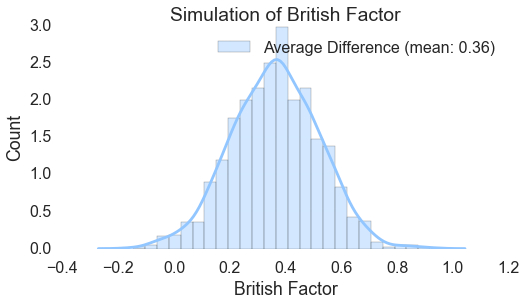

In [272]:
british_coef = []
 
for i in range(1000):
    subset = movie_df.take(np.random.permutation(len(movie_df))[:400])
    model = smf.ols("np.log(UK_Total_Gross) ~ np.log(Budget) + Genre + British", subset).fit()
    british_coef.append(model.params['British[T.1]'])


sns.set_palette("pastel")
plt.rc("figure", figsize=(8, 4))
british_label = "Average Difference (mean: " + str(round(np.mean(british_coef), 2)) + ")"
sns.distplot(british_coef, label=british_label);
plt.legend(loc='best')
plt.xlabel('British Factor')
plt.ylabel('Count')
plt.title('Simulation of British Factor')

This confirms my confidence in the British factor as the coefficient from my model was tested by taking random samples of movies from the dataframe, fitting a model, and storing the British coefficient.  These are then plotted to show the normal distribution about the mean of 0.36 which is very close to my original coefficient of 0.3247.  

##My recommendation:  Cast a British actor or actress in your next movie as a first step to a larger audience in the UK.